・性成熟したメス個体がmoving_rateで移出  
・性成熟したメス個体が移入  
　→年齢と個体数?  
年齢=cool_time+1、移入数=群れの性成熟したオスの数×移出率

In [23]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import statistics
random.seed(0)
np.random.seed(0)

In [24]:
# 個体クラスの定義
class Agent():
    def __init__(self, life_length, x=0.5, accident_rate=0):
        self.sex = np.random.choice(["m", "f"], p=[x, (1-x)])
        self.life_length = life_length
        self.age = 0
        self.death_rate = (1/life_length) + accident_rate # 年間の死亡割合


    # 歳を取る
    def aging(self):
        self.age += 1


    # 死亡判定処理
    def judge_death(self):
        # 寿命で死亡
        if self.age == self.life_length:
            return True
        # 一定の死亡率で死亡
        else:
            return np.random.choice([True, False], p=[self.death_rate, (1-self.death_rate)])

In [25]:
# シミュレーションクラスの定義

# firstsize:初期個体数、Nmax:個体数上限、life_length:寿命、cool_time:性成熟する年齢
# x:初期集団の性比、accident_rate:年間の事故での死亡割合、born_rate:流産しない割合、moving_rate:移出する割合

class Simulation():
    def __init__(self, firstsize, Nmax, life_length, cool_time, 
                 x=0.5, accident_rate=0, born_rate=1, moving_rate=0):

        self.population = self.__initialize(firstsize, life_length, x, accident_rate)
        self.Nmax = Nmax
        self.life_length = life_length
        self.cool_time = cool_time
        self.accident_rate = accident_rate
        self.born_rate = born_rate
        self.moving_rate = moving_rate


    # 初期集団をつくる
    def __initialize(self, firstsize, life_length, x, accident_rate):
        population = []

        # firstsizeとxに従って初期集団をつくる
        # 初期集団の個体の年齢はランダムに決定
        for i in range(firstsize):
            focal = Agent(life_length, x, accident_rate)
            focal.age = random.randrange(30)
            population.append(focal)
        
        return population


    # 移出させる
    # 性成熟した個体はmoving_rateの確率で移出
    def __moving_out(self):
        for i in range(len(self.population)):
            focal = self.population[i]
            if (focal.sex == 'f') and (focal.age > self.cool_time) and (np.random.rand() <= self.moving_rate):
                del focal

    
    # 移入させる
    # (オスの数*移出率)匹のメスが移入、年齢はcool_time+1
    def __moving_in(self):
        male_size = len([focal for focal in self.population if (focal.sex == 'm') and (focal.age > self.cool_time)])
        for _ in range(int(male_size * self.moving_rate)):
            focal = Agent(self.life_length, x=0, accident_rate=self.accident_rate)
            focal.age = (self.cool_time + 1)
            self.population.append(focal)


    # 集団内の交尾
    def __copulation(self):
        male_population = []
        female_population = []
        chosen_female = []

        # オスメスの振り分け
        # 生殖可能な個体を選ぶ
        for focal in self.population:
            if (focal.sex == 'm') and (focal.age > self.cool_time):
                male_population.append(focal)
            elif (focal.sex == 'f') and (focal.age > self.cool_time) :
                female_population.append(focal)

        # 流産しない個体を確率で選抜
        for focal in female_population:
            if np.random.rand() <= self.born_rate:
                chosen_female.append(focal)
        
        # メスが子供を産む
        for _ in chosen_female:
            self.population.append(Agent(
                self.life_length,
                accident_rate=self.accident_rate
            ))


    # 個体数抑制(短い世代を考えるのでほぼ機能しない？)
    def __population_control(self):
        while len(self.population) > int(self.Nmax):
            index = random.randrange(len(self.population))
            del self.population[index]

    
    # 1世代のシミュレーションを実行
    def run_one_episode(self):

        self.__moving_out()
        self.__moving_in()

        self.__copulation()

        for focal in self.population:
            focal.aging()
            if focal.judge_death():
                index = self.population.index(focal)
                del self.population[index]

        self.__population_control()

In [26]:
# main処理
def main(iteration, firstsize, Nmax, life_length, cool_time, x=0.5, accident_rate=0, born_rate=1, moving_rate=0):
    t = list(range(1, (iteration + 1)))
    population_size = []
    sexratio = []
    simulation = Simulation(firstsize, Nmax, life_length, cool_time, x, accident_rate, born_rate, moving_rate)
    
    for i in tqdm(range(iteration)):
        simulation.run_one_episode()

        male_size = 0
        for focal in simulation.population:
            if focal.sex == 'm':
                male_size += 1

        population_size.append(len(simulation.population))
        if len(simulation.population) != 0:
            sexratio.append(male_size / len(simulation.population))
        else:
            sexratio.append(0)

    plt.figure()
    plt.plot(t, sexratio)
    plt.title('sex ratio')
    plt.xlabel('Generations[year]')
    plt.ylabel('sex ratio')
    plt.grid(True)

    plt.figure()
    plt.plot(t, population_size)
    plt.title('population size')
    plt.xlabel('Generations[year]')
    plt.ylabel('population size')
    plt.grid(True)

100%|██████████| 50/50 [00:01<00:00, 36.11it/s] 


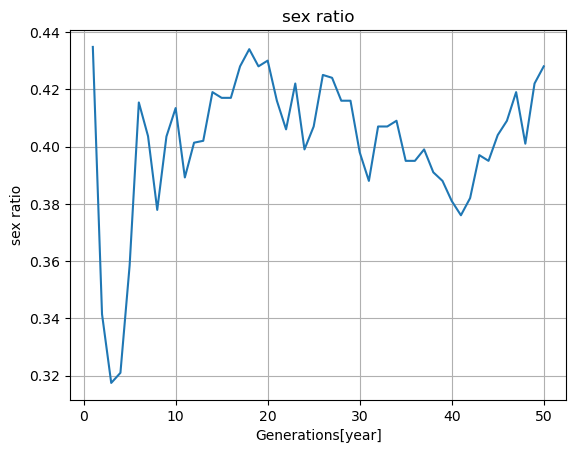

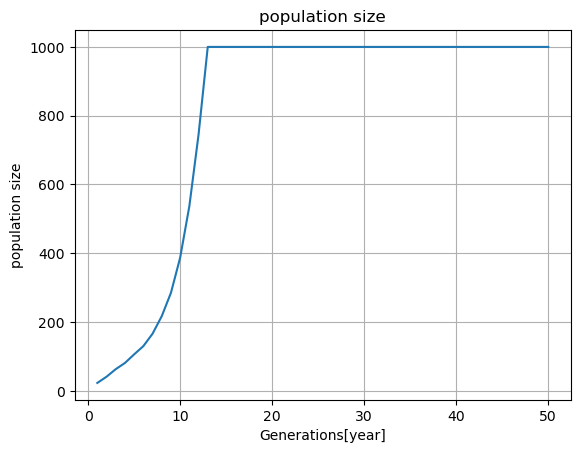

In [29]:
# main(iteration, firstsize, Nmax, life_length, cool_time, x, accident_rate=0, born_rate=1, moving_rate=0)
# 世代数:50、初期個体数:10、個体数上限:1000、寿命:30、性成熟の年齢:5
# 初期集団の性比:0.5、accident_rate:0, born_rate:1、移出率:1
main(50, 10, 1000, 30, 5, moving_rate=1)

100%|██████████| 50/50 [00:00<00:00, 82.02it/s] 


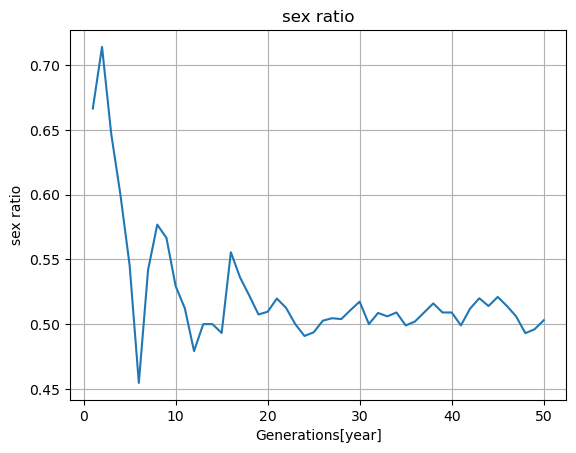

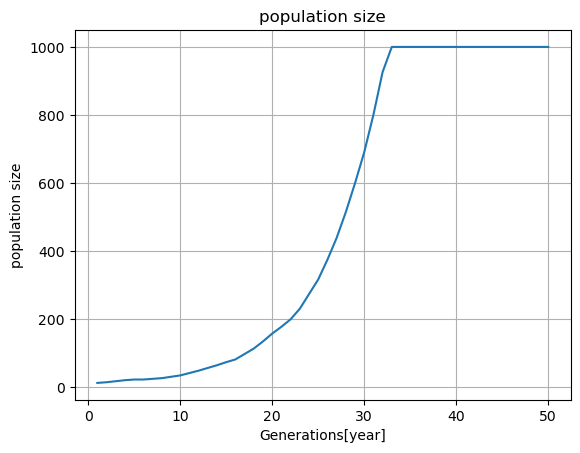

In [30]:
# 世代数:50、初期個体数:10、個体数上限:1000、寿命:30、性成熟の年齢:5
# 初期集団の性比:0.5、accident_rate:0, born_rate:1、移出率:0
main(50, 10, 1000, 30, 5)